In [5]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
import mfmodel as mfm

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [7]:
mtype = "mlr_hier_cov_gics"
rank = 30
n = 5000
signal_to_noise = 4


nsamples = 300
L = 6

ranks = np.array([14, 6, 4, 3, 2, 1])

In [8]:
with open("../../mlr_fitting_private/data_finance/crsp_gics_5k_hpart.pkl", "rb") as f:
       hpart = pickle.load(f)
part_sizes = mfm.print_hpart_numgroups(hpart)

level=0, num_groups=1, mean_size=5000.0
level=1, num_groups=11, mean_size=454.5
level=2, num_groups=24, mean_size=208.3
level=3, num_groups=69, mean_size=72.5
level=4, num_groups=157, mean_size=31.8
level=5, num_groups=5000, mean_size=1.0


In [9]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise)

signal_var=28.967422298555448, noise_var=7.201470189973824
SNR=4.02243174440756, signal_to_noise=4


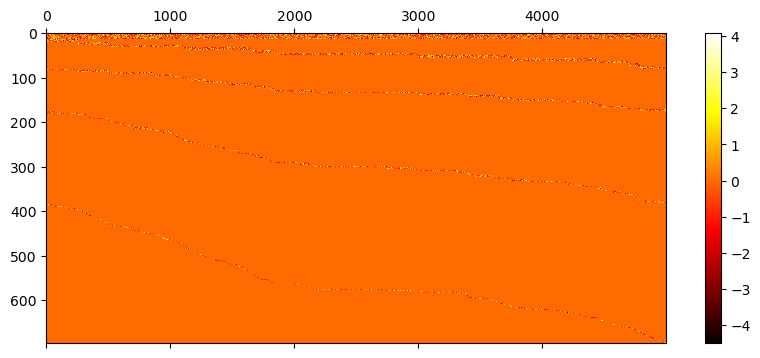

(5000, 697)


In [10]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [11]:
C = mfm.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)

Z = (C - C.mean(axis=1, keepdims=True))[hpart["rows"]["pi"], :]
unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[true_mlr.pi_inv_rows, :][:, true_mlr.pi_inv_cols]

# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

In [13]:
np.sort(np.abs(np.linalg.eigvalsh(unpermuted_A)))[::-1][:10]

array([7459.76480331, 6651.63493482, 6322.78866081, 6247.50212839,
       6057.90796306, 5822.05796575, 5597.89420466, 5375.322221  ,
       5156.72338875, 4835.98106911])

In [12]:
Y.mean(), Y.max(), Y.min(), np.median(Y)

(-9.497587901326673e-19,
 33.66490170474131,
 -36.74830019318862,
 -0.003275751273309431)

In [8]:
type(true_sparse_F)

numpy.ndarray

In [9]:
perm_true_covariance = true_sparse_F @ true_sparse_F.T + np.diag(true_D_noise)
np.linalg.norm(unpermuted_A[hpart["rows"]["pi"], :][:, hpart["rows"]["pi"]] - perm_true_covariance, 'fro') / np.linalg.norm(perm_true_covariance, 'fro') 

0.5254704220716414

In [10]:
C.shape, Z.shape, unpermuted_A.shape

((5000, 300), (5000, 300), (5000, 5000))

In [11]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [12]:
row_selectors, si_groups, F_hpart = mfm.row_col_selections(hpart)

num_levels=6, num_sparsities=157
(157, 5) [  0  10  23  68 156]


# True model loglikelihoods

In [13]:
true_Sigma = mfm.perm_hat_Sigma_sp(true_sparse_F, true_D_noise)
tr_lu, tr_piv = scipy.linalg.lu_factor(true_Sigma)
true_train_obj = mfm.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y)
exp_true_ll = mfm.exp_true_loglikelihood_value(true_Sigma)
print(f"TR: train ll={true_train_obj}, exp ll={exp_true_ll}")

TR: train ll=-12195.82265977308, exp ll=-12204.739769552163


In [14]:
assert np.allclose(exp_true_ll, mfm.exp_loglikelihood_value(true_Sigma, true_Sigma, tr_lu, tr_piv))

In [15]:
np.linalg.slogdet(true_Sigma), true_sparse_F.shape

((1.0, 10220.0942070576), (5000, 697))

# Frobenius norm-based loss

In [16]:
obj_frobs = {}

print(ranks.sum())
hat_A = mf.MLRMatrix()
hat_A.hpart = hpart
losses = hat_A.factor_fit(unpermuted_A, ranks, hat_A.hpart, eps_ff=1e-3, PSD=True, freq=1, \
                                printing=True, max_iters_ff=50, symm=True)

F_frob, D_frob = hat_A.B[:, :-1], np.square(hat_A.B[:, -1])
Sigma_frob = mfm.perm_hat_Sigma(F_frob, D_frob, F_hpart, ranks)
frob_lu, frob_piv = scipy.linalg.lu_factor(Sigma_frob)
obj_frob = mfm.loglikelihood_value(Sigma_frob, frob_lu, frob_piv, Y)

exp_obj_frob = mfm.exp_loglikelihood_value(true_Sigma, Sigma_frob, frob_lu, frob_piv)
print(f"FR: train ll={obj_frob}, exp ll={exp_obj_frob}, {losses[-1]=}")
obj_frobs[str(ranks)] = {"train":obj_frob, "exp":exp_obj_frob}

30


/Users/parshakova.tanya/Documents/projects/MLR_Matrices/mlr_fitting/mlrfit/utils.py:408: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


itr=0, 0.2721895700072558, [14  6  4  3  2  1]
itr=1, 0.2721895700072558, [14  6  4  3  2  1]
itr=1, 0.2678288538864321, [14  6  4  3  2  1], time_v_epoch=11.129950046539307, time_loss=0.7922170162200928
itr=2, 0.26722932627542767, [14  6  4  3  2  1], time_v_epoch=11.508006811141968, time_loss=0.8485147953033447
itr=3, 0.2667903905502956, [14  6  4  3  2  1], time_v_epoch=11.794763803482056, time_loss=0.7668910026550293
itr=4, 0.2664566750381608, [14  6  4  3  2  1], time_v_epoch=12.050909996032715, time_loss=0.7512140274047852
itr=5, 0.2662101984446479, [14  6  4  3  2  1], time_v_epoch=10.81026291847229, time_loss=0.7377691268920898
FR: train ll=-11990.498039121776, exp ll=-12585.806084417562, losses[-1]=0.26611262248690215


In [17]:
mf.rel_diff(hat_A.matrix(), den=unpermuted_A), np.linalg.slogdet(hat_A.matrix())

(0.26611262248690204, (1.0, 9793.790275782112))

# MLE-based loss

In [18]:
loglikelihoods, F0, D0 = mfm.em_algorithm(n, Y, part_sizes, F_hpart, row_selectors, si_groups, 
                                         ranks, max_iter=300, eps=1e-8, printing=True, freq=1) 

t=0, obj=-15864.690969512434
t=1, obj=-14186.854463172447
t=2, obj=-13367.109100232266
t=3, obj=-12903.294085900656
t=4, obj=-12639.74596000455
t=5, obj=-12477.073910390414
t=6, obj=-12372.976758783838
t=7, obj=-12305.118692576118
t=8, obj=-12257.845517807114
t=9, obj=-12223.399449894643
t=10, obj=-12198.382976169923
t=11, obj=-12179.913039761497
t=12, obj=-12165.481561570767
t=13, obj=-12153.60316305969
t=14, obj=-12143.562786086279
t=15, obj=-12134.822767648471
t=16, obj=-12127.001348923506
t=17, obj=-12119.92422750051
t=18, obj=-12113.560013432463
t=19, obj=-12107.813245820422
t=20, obj=-12102.569775540826
t=21, obj=-12097.750670628096
t=22, obj=-12093.304201730578
t=23, obj=-12089.193532745217
t=24, obj=-12085.385594761661
t=25, obj=-12081.846423098053
t=26, obj=-12078.542585837431
t=27, obj=-12075.445597228212
t=28, obj=-12072.5345427438
t=29, obj=-12069.793601635298
t=30, obj=-12067.208083184949
t=31, obj=-12064.762766540593
t=32, obj=-12062.442548120052
t=33, obj=-12060.23365709

In [60]:
ll_hier = np.copy(np.array(loglikelihoods))

In [61]:
Sigma0 = mfm.perm_hat_Sigma(F0, D0, F_hpart, ranks)
mf.rel_diff(Sigma0, den=unpermuted_A[hat_A.pi_rows, :][:, hat_A.pi_cols]), np.linalg.slogdet(Sigma0)

(0.7250215577026562, (1.0, 9658.282700761549))

In [62]:
mle_lu, mle_piv = scipy.linalg.lu_factor(Sigma0)
exp_mle_obj = mfm.exp_loglikelihood_value(true_Sigma, Sigma0, mle_lu, mle_piv)

print(f"ML: train ll={loglikelihoods[-1]}, exp ll={exp_mle_obj}")
ll_hier = {"train":ll_hier, "exp":exp_mle_obj}

ML: train ll=-11948.016273254547, exp ll=-12536.248972787238


In [63]:
obj_frobs[str(ranks)]

{'train': -11990.498039121776, 'exp': -12585.806084417562}

In [4]:
-12536 + 12584, -11948 + 11990

(48, 42)

In [2]:
-11948.016273254547 - (-11990.498039121776), -12536.248972787238 - (-12585.806084417562)

(42.481765867229115, 49.55711163032356)

In [64]:
with open(f"outputs/em_{mtype}.pickle", 'wb') as handle:
    lls = {"hier":ll_hier, "frob":obj_frobs}
    pickle.dump(lls, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [65]:
# true model maximizes the expected likelihood of data sample
assert exp_true_ll > obj_frobs[str(ranks)]["exp"] and exp_true_ll > ll_hier["exp"]
print(exp_true_ll, ll_hier["exp"], obj_frobs[str(ranks)]["exp"], ll_hier["exp"] - obj_frobs[str(ranks)]["exp"])

-12204.739769552163 -12536.248972787238 -12585.806084417562 49.55711163032356


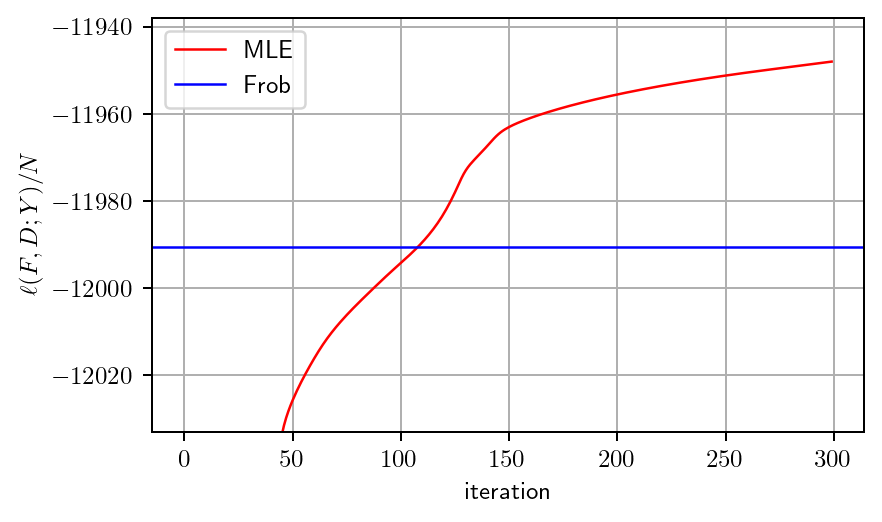

In [67]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}"
})
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=180, sharey=True)

ll = ll_hier["train"][1:]
# print(f"{ranks=}, difference={(ll[-1]-obj_frobs[str(ranks)]["train"]):.2f}, %increase={(ll[-1]-obj_frobs[str(ranks)]["train"])/obj_frobs[str(ranks)]["train"]*100:.2f}")
axs.plot(ll, color='r', lw=1, label=r"$\text{MLE}$")
axs.set_xlabel('iteration')
axs.axhline(obj_frobs[str(ranks)]["train"], 0, ll.size-1, color='b', lw=1, label=r"$\text{Frob}$")
axs.set_ylabel(r'$\ell(F, D; Y)/N$')
# axs.set_yscale('symlog')
axs.set_ylim([ll.max() - 85, ll.max() + 10])
axs.grid(True)
axs.legend()
    # axs[i].set_title(f"ranks$={list(ranks)}$")
# plt.show()
plt.tight_layout()
plt.savefig(f"plots/em_{mtype}.pdf", bbox_inches='tight')

In [49]:
assert Z.shape[1] == nsamples

In [28]:
np.linalg.slogdet(hat_A.matrix())

(1.0, 9793.790275782112)

In [35]:
loglikelihoods = loglikelihoods[:51] + loglikelihoods[52:]